In [27]:
import numpy as np
from scipy import optimize
from numba import vectorize, float32, float64
import torch
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['science','notebook'])

import sys
sys.path.insert(0, '../src/pydftlj/')
from dft3dgpu import dft3d
from eos import LJEOS 

from pymatgen.core import Structure
from pymatgen.analysis import structure_matcher

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2023-05-03

In [28]:
kB = 1.380649e-23 # J/K
Rconst = 0.082057366080960 # Gas constant
NA = 6.022e23 # Avogadro number

## Solid CIF file Information

In [29]:
structure_name = 'MOF-5'
structure = Structure.from_file('../structures/'+structure_name+'.cif')
Ncell = 2
structure.make_supercell(Ncell)
print('formula:  ', structure.formula)
print('num_sites:', structure.num_sites)

formula:   Zn256 H768 C1536 O832
num_sites: 3392


In [30]:
coordinates = structure.cart_coords.T
L = np.array([l/Ncell for l in structure.lattice.lengths])
print('Cell dimensions: ', L)
Vcell = L[0]*L[1]*L[2]
print('Cell volume: ', Vcell)

Cell dimensions:  [25.86584 25.86584 25.86584]
Cell volume:  17305.325019903623


# Force Field for solid-fluid interaction

In [31]:
forcefield_name = 'DREIDING'
forcefield = pd.read_csv('../parameters/'+forcefield_name+'-forcefield.dat',delim_whitespace=True)
forcefield

,atom,sigma/AA,epsilon/kB,mass/u
0,H,2.84642,7.64893,1.00784
1,C,3.47299,47.85620,12.01070
2,N,3.26256,38.94920,14.00670
3,O,3.03315,48.15810,15.99900
4,Cu,3.11369,2.51610,63.54600
5,Zn,4.04468,27.67710,65.38000


# Fluid Information

In [32]:
# PCSAFT: Gross, J., & Sadowski, G. (2001). Industrial & Engineering Chemistry Research, 40(4), 1244–1260.
# TraPPE: M.G. Martin, and J.I. Siepmann, J. Phys. Chem. B 102, 2569-2577 (1998).
# SoftSAFT: Blas, F. J., & Vega, L. F. (1998). Industrial and Engineering Chemistry Research, 5885(1996), 660–674.
fluid_molecule = 'CH4'
epsilon = {'TraPPE': 148.0, 'PCSAFT': 150.03, 'SoftSAFT': 147.302}
sigma = {'TraPPE': 3.73, 'PCSAFT': 3.704, 'SoftSAFT': 3.722}

fluid_forcefield = 'TraPPE'
epsilonff = epsilon[fluid_forcefield] # kelvin
sigmaff = sigma[fluid_forcefield] # angstrom
mff = 16.043
# epsilonff = 10.22 # kelvin
# sigmaff = 2.58 # angstrom
# mff = 4.0026

# Create the DFT object

In [33]:
Ngrid = 32
DFT = dft3d(gridsize=np.array([Ngrid,Ngrid,Ngrid]))
DFT.Set_Geometry(L)

In [34]:
DFT.GetSystemInformation()

============== The DFT 3D for LJ fluids ==============
Methods:
The grid is [32 32 32]
--- Geometry properties ---
Lx = 25.86584  A
Ly = 25.86584  A
Lz = 25.86584  A
Vol = 17305.325019903623  A³


In [35]:
DFT.Set_FluidProperties(sigma=sigmaff,epsilon=epsilonff)

In [36]:
DFT.GetFluidInformation()

--- Fluid properties ---
epsilon/kB = 148.0  K
sigma = 3.73  A


## Defining the Temperature

In [37]:
kT = 300.0 # kelvin 

DFT.Set_Temperature(kT)

In [38]:
DFT.GetFluidTemperatureInformation()

Temperature = 300.0  K
Baker-Henderson diameter = 3.567  A


## Generating the External Potential

In [39]:
@vectorize
def ljpotential(r,eps,sigma):
    return 4*eps*((sigma/r)**(12)-(sigma/r)**(6))

In [40]:
%%time

mss = 0.0

Vext = np.zeros((Ngrid,Ngrid,Ngrid))

# Lorentz-Berthelot combination rule
for i, site in enumerate(structure):
    sigmasf = float(0.5*(sigmaff+forcefield["sigma/AA"][forcefield["atom"]==site.species_string]))
    epsilonsf = float(np.sqrt(epsilonff*forcefield["epsilon/kB"][forcefield["atom"]==site.species_string]))
    mss += float(forcefield["mass/u"][forcefield["atom"]==site.species_string])

    R = np.sqrt((DFT.X-structure.cart_coords[i,0]+L[0])**2 + (DFT.Y-structure.cart_coords[i,1]+L[1])**2 + (DFT.Z-structure.cart_coords[i,2]+L[2])**2)
    Vext[:] += ljpotential(R,epsilonsf,sigmasf)

mss = mss/(Ncell**3)

del R

DFT.Set_External_Potential(Vext)

CPU times: user 15 s, sys: 8.02 ms, total: 15 s
Wall time: 15 s


In [41]:
print('Unit cell mass: ', mss, ' u')

Unit cell mass:  6158.863039999983  u


In [42]:
rhocr = 1e27*mss/(Vcell*NA) #kg/m3 crystal MOF-5 density

In [43]:
print('Crystal Density: ',rhocr,' kg/m3')

Crystal Density:  590.9898672923852  kg/m3


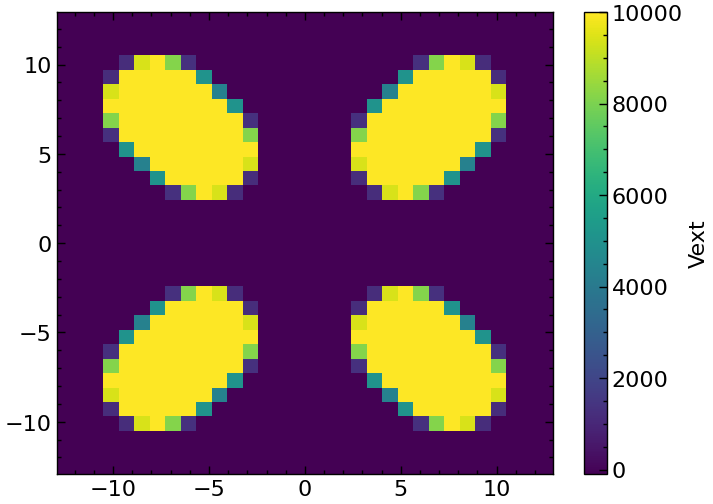

In [44]:
plt.figure(figsize=(8,6))
c=plt.pcolormesh(DFT.X[:,:,Ngrid//2],DFT.Y[:,:,Ngrid//2],DFT.Vext[:,:,Ngrid//2].cpu(), cmap='viridis',vmin=-1e2,vmax=1e4)
plt.colorbar(label='Vext')
plt.show()

In [45]:
# helium_void_fraction = Vpore/Vcell
helium_void_fraction = 0.852
# helium_void_fraction = 0.815

In [46]:
Vpore = helium_void_fraction*Vcell

In [47]:
ljeos= LJEOS(sigma=sigmaff,epsilon=epsilonff,model='MBWR')

In [48]:
def rhofromBARpressure(pbar):
    def func(x,p):
        return ljeos.p(x,kT)-p,ljeos.dpdrho(x,kT), ljeos.d2pdrho2(x,kT)
    if np.isscalar(pbar):
        sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar/(1e-5*kB)), method='halley')
        rho = sol.root
    else:
        rho = np.empty_like(pbar)
        for i in range(pbar.size):
            sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar[i]/(1e-5*kB)), method='halley')
            rho[i] = sol.root
    return rho

In [49]:
pbararray = np.hstack((np.arange(0.2,2.0,0.2),np.arange(2.,71.,1.0)))

In [50]:
rhobarray = rhofromBARpressure(pbararray)

Text(0, 0.5, '$\\rho$ (molecules/$\\AA^{3}$)')

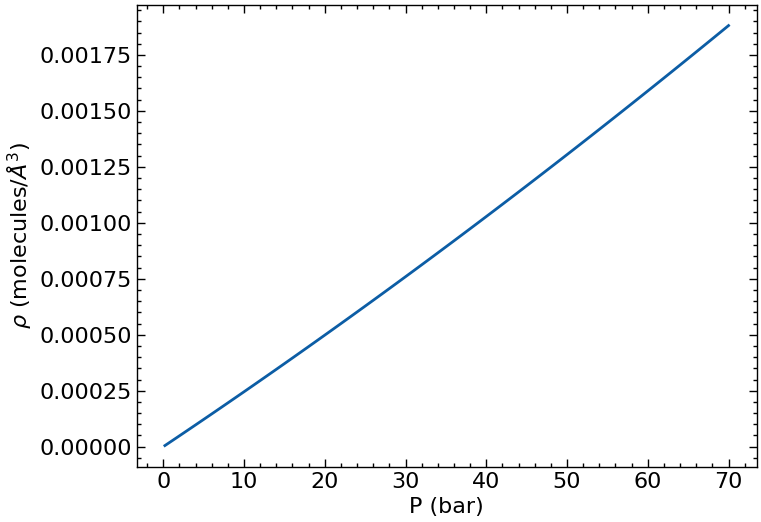

In [51]:
plt.plot(pbararray,rhobarray)
plt.xlabel(r'P (bar)')
plt.ylabel(r'$\rho$ (molecules/$\AA^{3}$)')

In [52]:
%%time

Nadsarray = np.zeros_like(rhobarray)

DFT.Set_BulkDensity(rhobarray[0])
DFT.Set_InitialCondition()

print('P (bar)\t rhob (AA^-3)\t Nabs(molecules/u.c.)')

for i in range(rhobarray.size):
    rhob = rhobarray[i]

    DFT.Set_BulkDensity(rhob)

    # DFT.Calculate_Equilibrium(alpha0=0.25,rtol=1e-2,atol=1e-4,max_iter=20,method='picard',logoutput=False)
    DFT.Calculate_Equilibrium(alpha0=0.25,dt=0.3,rtol=1e-3,atol=1e-4,method='fire',logoutput=False)

    Nadsarray[i] = DFT.Nadstot
    print(pbararray[i],rhob,Nadsarray[i])

P (bar)	 rhob (AA^-3)	 Nabs(molecules/u.c.)
0.2 4.830183239486023e-06 0.5825378894805908
0.4 9.663439381764144e-06 1.1692062616348267
0.6000000000000001 1.4499769095510134e-05 1.7578786611557007
0.8 1.9339173050529526e-05 2.3484864234924316
1.0 2.418165191772628e-05 2.9410207271575928
1.2 2.9027206369070936e-05 3.5354225635528564
1.4000000000000001 3.3875837077568424e-05 4.131598472595215
1.6 3.8727544717225255e-05 4.729485511779785
1.8 4.3582329963016495e-05 5.328986644744873
2.0 4.8440193490852e-05 5.930021286010742
3.0 7.277570907864279e-05 8.954496383666992
4.0 9.718828358056565e-05 12.002955436706543
5.0 0.00012167800232387535 15.065430641174316
6.0 0.0001462449509437831 18.12303924560547
7.0 0.00017088921525607772 21.1654109954834
8.0 0.00019561088112207125 24.180078506469727


/home/elvis/Google Drive/Projetos em Andamento/2-DFT in Amorphous Carbon/codes/PyDFTlj/examples/../src/pydftlj/dft3dgpu.py:169: RuntimeWarning: invalid value encountered in dphi3dnfuncWBI
  self.dphi3dn3 = torch.tensor(dphi3dnfuncWBI(self.n3.numpy()),dtype=torch.float32)


9.0 0.00022041003430574202 27.155500411987305
10.0 0.00024528676032294945 30.081592559814453
11.0 0.0002702411442825972 32.94599533081055
12.0 0.000295273270719622 35.74843978881836
13.0 0.0003203832234196888 38.4809455871582
14.0 0.00034557108523547447 41.13957977294922
15.0 0.0003708369378944238 43.72157669067383
16.0 0.0003961808617978667 46.22538375854492
17.0 0.00042160293581138583 48.65050506591797
18.0 0.0004471032370463291 50.99717712402344
19.0 0.00047268184063236376 53.26911163330078
20.0 0.0004983388194809746 55.46100997924805
21.0 0.0005240742440398102 57.57819366455078
22.0 0.0005498881820377885 59.621639251708984
23.0 0.0005757806982208785 61.595970153808594
24.0 0.0006017518540784753 63.501827239990234
25.0 0.000627801707560302 65.34163665771484
26.0 0.0006539303127837639 67.11775207519531
27.0 0.0006801377197317032 68.83255767822266
28.0 0.000706423973940502 70.48866271972656
29.0 0.0007327891161784805 72.08802795410156
30.0 0.0007592331821145722 73.63310241699219
31.0 

In [53]:
Marray = mff*Nadsarray

Nbulkarray = rhobarray*Vpore
Mbulk = mff*Nbulkarray

In [54]:
Nidealarray = rhobarray*torch.exp(-DFT.beta*DFT.Vext[:,:,:].cpu()).sum().numpy()*DFT.dV
Midealarray = mff*Nidealarray

In [55]:
Nexcarray = Nadsarray - rhobarray*Vpore
Mexcarray = Nexcarray*mff

In [56]:
df = pd.DataFrame()
df['Pressure (bar)'] = pbararray
df['Bulk adsorption (molecules/uc)'] = Nbulkarray
df['Bulk adsorption (%w.t.)'] = 100*Mbulk/(mss+Mbulk)
df['Bulk adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/101325)*Nbulkarray/Vcell
df['Ideal adsorption (molecules/uc)'] = Nidealarray
df['Ideal adsorption (%w.t.)'] = 100*Midealarray/(mss+Midealarray)
df['Ideal adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/101325)*Nidealarray/Vcell
df['Absolute adsorption (molecules/uc)'] = Nadsarray
df['Absolute adsorption (mg/g)'] = 1e3*Marray/mss
df['Absolute adsorption (%w.t.)'] = 100*Marray/(mss+Marray)
df['Absolute adsorption (mol/kg)'] = 1e3*Nadsarray/mss
df['Absolute adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/101325)*Nadsarray/Vcell
df['Excess adsorption (molecules/uc)'] = Nexcarray
df['Excess adsorption (mg/g)'] = 1e3*Mexcarray/mss
df['Excess adsorption (%w.t.)'] = 100*Mexcarray/(mss+Marray)
df['Excess adsorption (mol/kg)'] = 1e3*Nexcarray/mss
df['Excess adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/101325)*Nexcarray/Vcell

In [57]:
df.head()

,Pressure (bar),Bulk adsorption (molecules/uc),Bulk adsorption (%w.t.),Bulk adsorption (cm^3 STP/cm^3),Ideal adsorption (molecules/uc),Ideal adsorption (%w.t.),Ideal adsorption (cm^3 STP/cm^3),Absolute adsorption (molecules/uc),Absolute adsorption (mg/g),Absolute adsorption (%w.t.),Absolute adsorption (mol/kg),Absolute adsorption (cm^3 STP/cm^3),Excess adsorption (molecules/uc),Excess adsorption (mg/g),Excess adsorption (%w.t.),Excess adsorption (mol/kg),Excess adsorption (cm^3 STP/cm^3)
0,0.2,0.071217,0.018548,0.153169,0.583231,0.151693,1.254379,0.582538,1.517432,0.151513,0.094585,1.252888,0.511321,1.331922,0.132990,0.083022,1.099719
1,0.4,0.142479,0.037100,0.306436,1.166833,0.303023,2.509556,1.169206,3.045623,0.303638,0.189841,2.514660,1.026727,2.674485,0.266636,0.166707,2.208224
2,0.6,0.213787,0.055657,0.459800,1.750807,0.453991,3.765532,1.757879,4.579035,0.455816,0.285423,3.780742,1.544092,4.022150,0.400382,0.250711,3.320942
3,0.8,0.285139,0.074220,0.613261,2.335151,0.604597,5.022305,2.348486,6.117488,0.608029,0.381318,5.050986,2.063347,5.374738,0.534206,0.335021,4.437725
4,1.0,0.356538,0.092787,0.766820,2.919867,0.754844,6.279878,2.941021,7.660959,0.760271,0.477527,6.325374,2.584483,6.732227,0.668104,0.419636,5.558554


(0.0, 300.0)

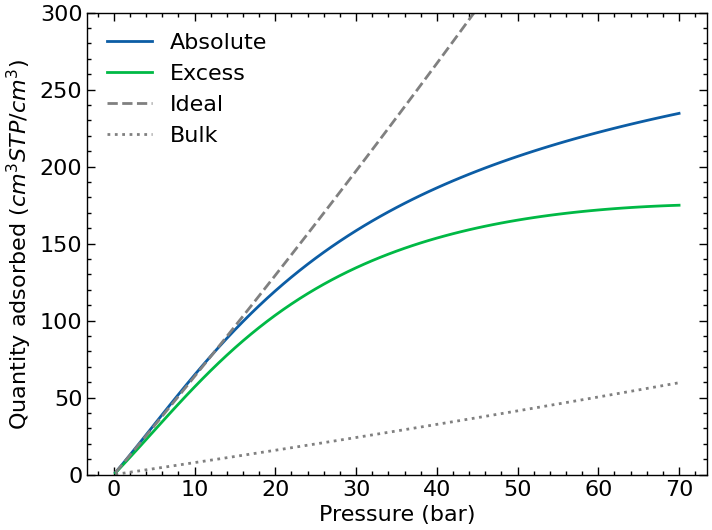

In [58]:
plt.plot(df['Pressure (bar)'],df['Absolute adsorption (cm^3 STP/cm^3)'],label='Absolute')
plt.plot(df['Pressure (bar)'],df['Excess adsorption (cm^3 STP/cm^3)'],label='Excess')
plt.plot(df['Pressure (bar)'],df['Ideal adsorption (cm^3 STP/cm^3)'],'--',color='grey',label='Ideal')
plt.plot(df['Pressure (bar)'],df['Bulk adsorption (cm^3 STP/cm^3)'],':',color='grey',label='Bulk')
plt.legend(loc='best')
plt.ylabel('Quantity adsorbed $(cm^3 STP/cm^3)$')
plt.xlabel('Pressure (bar)')
plt.ylim(0,300)

In [59]:
df.to_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-'+fluid_forcefield+'-'+forcefield_name+'-T='+str(kT)+'K-N='+str(Ngrid)+'.dat', index=False,sep='\t')

In [60]:
dft240K_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-PCSAFT-DREIDING-T=240.0K-N=32.dat',sep='\t')
dft270K_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-PCSAFT-DREIDING-T=270.0K-N=32.dat',sep='\t')
dft300K32_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=300.0K-N=32.dat',sep='\t')
dft300K64_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=300.0K-N=64.dat',sep='\t')

# Plotting the results

In [61]:
exp_data = pd.read_excel('data/experimental/H2andCH4-MOFandZIF-isotherm-Zhou2007.xls',sheet_name='CH4-MOF5')

(0.0, 35.0)

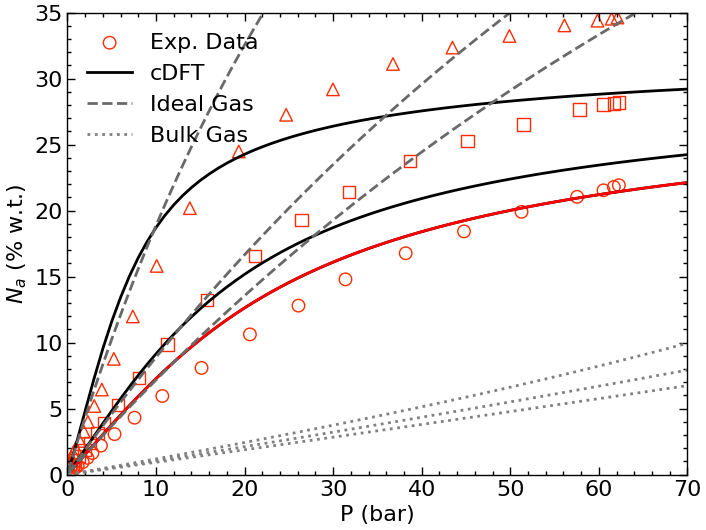

In [62]:
plt.rcParams["lines.markersize"] = 9

plt.scatter(exp_data['P(bar)-300K'],exp_data['Na(%wt)-300K'],marker='o',edgecolors='C3',facecolors='none',label='Exp. Data')
plt.scatter(exp_data['P(bar)-270K'],exp_data['Na(%wt)-270K'],marker='s',edgecolors='C3',facecolors='none')
plt.scatter(exp_data['P(bar)-240K'],exp_data['Na(%wt)-240K'],marker='^',edgecolors='C3',facecolors='none')

plt.plot(dft240K_data['Pressure (bar)'],dft240K_data['Absolute adsorption (%w.t.)'],'-',color='k',label='cDFT')
plt.plot(dft270K_data['Pressure (bar)'],dft270K_data['Absolute adsorption (%w.t.)'],'-',color='k')
plt.plot(dft300K32_data['Pressure (bar)'],dft300K32_data['Absolute adsorption (%w.t.)'],'-',color='k')

plt.plot(df['Pressure (bar)'],df['Absolute adsorption (%w.t.)'],'-',color='red')

plt.plot(dft240K_data['Pressure (bar)'],dft240K_data['Ideal adsorption (%w.t.)'],'--',color='dimgrey')
plt.plot(dft270K_data['Pressure (bar)'],dft270K_data['Ideal adsorption (%w.t.)'],'--',color='dimgrey')
plt.plot(dft300K32_data['Pressure (bar)'],dft300K32_data['Ideal adsorption (%w.t.)'],'--',color='dimgrey',label='Ideal Gas')

plt.plot(dft240K_data['Pressure (bar)'],dft240K_data['Bulk adsorption (%w.t.)'],':',color='grey')
plt.plot(dft270K_data['Pressure (bar)'],dft270K_data['Bulk adsorption (%w.t.)'],':',color='grey')
plt.plot(dft300K32_data['Pressure (bar)'],dft300K32_data['Bulk adsorption (%w.t.)'],':',color='grey',label='Bulk Gas')

plt.legend(loc='upper left')
plt.xlabel('P (bar)')
plt.ylabel('$N_a$ (% w.t.)')
plt.xlim(0,70)
plt.ylim(0,35)

In [63]:
exp_data2 = pd.read_excel('data/experimental/CH4-MOF-isotherm-Duren2004.xls',sheet_name='IRMOF-1')

(0.0, 150.0)

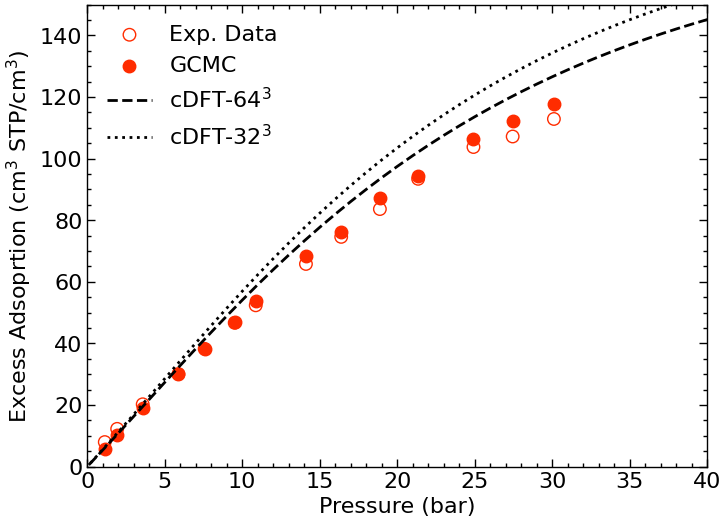

In [65]:
plt.rcParams["lines.markersize"] = 9

plt.scatter(exp_data2['Pressure (atm)']/0.986923,exp_data2['Excess adsorption (cm^3 STP/cm^3)'],marker='o',edgecolors='C3',facecolors='none',label='Exp. Data')
plt.scatter(exp_data2['Pressure (atm)']/0.986923,exp_data2['Sim Excess adsorption (cm^3 STP/cm^3)'],marker='o',edgecolors='C3',facecolors='C3',label='GCMC')

# plt.plot(df['Pressure (bar)'],df['Excess adsorption (cm^3 STP/cm^3)'],'-',color='k',label='cDFT-128$^3$')

plt.plot(dft300K64_data['Pressure (bar)'],dft300K64_data['Excess adsorption (cm^3 STP/cm^3)'],'--',color='k',label='cDFT-64$^3$')

plt.plot(dft300K32_data['Pressure (bar)'],dft300K32_data['Excess adsorption (cm^3 STP/cm^3)'],':',color='k',label='cDFT-32$^3$')

# plt.plot(dft300K_data['Pressure (bar)'],dft300K_data['Ideal adsorption (cm^3 STP/cm^3)'],'--',color='dimgrey',label='Ideal Gas')

# plt.plot(dft300K_data['Pressure (bar)'],dft300K_data['Bulk adsorption (cm^3 STP/cm^3)'],':',color='grey',label='Bulk Gas')

plt.legend(loc='upper left')
plt.xlabel('Pressure (bar)')
plt.ylabel('Excess Adsoprtion (cm$^3$ STP/cm$^3$)')
plt.xlim(0,40)
plt.ylim(0,150)